# Практика. Статистические тесты в контексте EDA

## Постановка задачи

### ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

HR-агентства хочет ответить на следующие вопросы, касающиеся заработной платы:

* Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
* Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
* Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
* Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные о зарплатах в сфере Data Science за 2020–2022 годы.

Данные содержат следующие столбцы:

* work_year — Год, в котором была выплачена зарплата;
* experience_level — Опыт работы на этой должности в течение года со следующими возможными значениями: 
    * EN (Entry-level/Junio)
    * MI (Mid-level/Intermediate)
    * SE (Senior-level/Expert)
    * EX (Executive-level/Director);
* employment_type — Тип трудоустройства для этой роли:
    * PT (неполный рабочий день)
    * FT (полный рабочий день)
    * CT (контракт)
    * FL (фриланс);
* job_title — Роль, в которой соискатель работал в течение года;
* salary — Общая выплаченная валовая сумма заработной платы;
* salary_currency — Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
* salary_in_usd — Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com);
* employee_residence — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
* remote_ratio — Общий объём работы, выполняемой удалённо. Возможные значения:
    * 0 - (удалённой работы нет (менее 20 %))
    * 50 - (частично удалённая работа)
    * 100 - (полностью удалённая работа (более 80 %));
* company_location — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* company_size — Среднее количество людей, работавших в компании в течение года:
    * S - (менее 50 сотрудников (небольшая компания))
    * M - (от 50 до 250 сотрудников (средняя компания))
    * L - (более 250 сотрудников (крупная компания)).

Оригинальный датасет: ["Data Science Job Salaries” (kaggle.com)"](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

### **Загрузка данных**

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# загружаем датасет
data = pd.read_csv('ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


### **Описательный анализ данных**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


<Axes: >

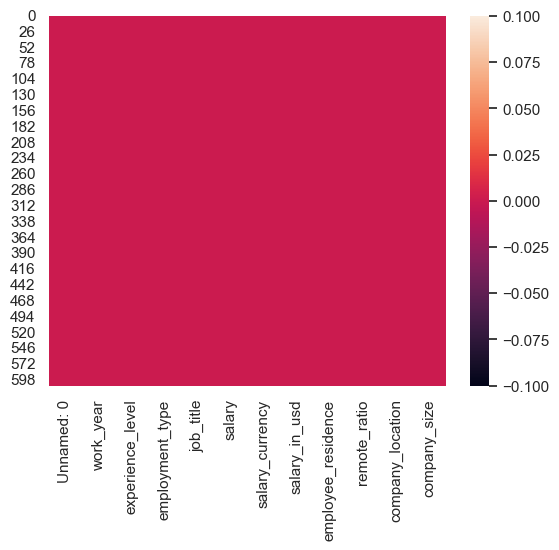

In [5]:
sns.heatmap(data.isnull()) # проверим, что датасет без пропусков

    Вывод: В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов, удалим признак salary, аналогичный более универсальному и поддающемуся статестической оработке признаку salary_in_usd, удалим признак salary_currency, поскольку мы будем оперировать зарплатой уже переведенной в доллары США. Так же будет удален признак Unnamed не имеющий значения для статистического анализа.

In [6]:
# Проверяем наличие дубликатов:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))
# Удаляем столбцы "salary" и "salary_currency" из DataFrame
data = data.drop(columns=['salary', 'salary_currency'])
data.info()

Количество дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary_in_usd       607 non-null    int64 
 6   employee_residence  607 non-null    object
 7   remote_ratio        607 non-null    int64 
 8   company_location    607 non-null    object
 9   company_size        607 non-null    object
dtypes: int64(4), object(6)
memory usage: 47.6+ KB


**Проведём корреляционный анализ датасета**

*Используем для этого тепловую карту корреляций признаков*

<Axes: >

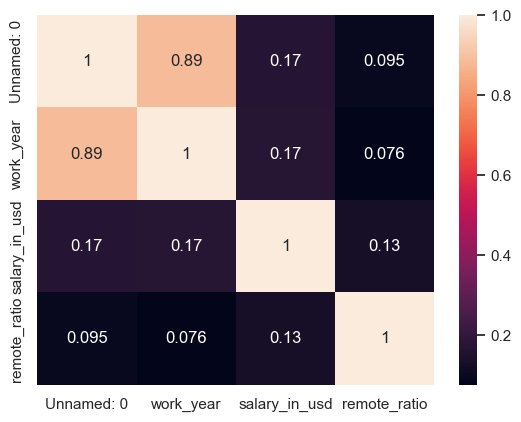

In [7]:
# отсеиваем числовые признаки и включаем отображение коэффициентов
sns.heatmap(data.corr(numeric_only=True), annot=True)

    Вывод: В датасете нет неинформативных признаков которые из за мультиколлениарности с другими признаками подлежали бы исключению

### **Классификация признаков на числовые и категориальные**

Категориальные признаки:

* work_year — Год, в котором была выплачена зарплата;
* experience_level — Опыт работы на этой должности в течение года со следующими возможными значениями: 
    * EN (Entry-level/Junio)
    * MI (Mid-level/Intermediate)
    * SE (Senior-level/Expert)
    * EX (Executive-level/Director);
* employment_type — Тип трудоустройства для этой роли:
    * PT (неполный рабочий день)
    * FT (полный рабочий день)
    * CT (контракт)
    * FL (фриланс);
* job_title — Роль, в которой соискатель работал в течение года;
* employee_residence — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
* remote_ratio — Общий объём работы, выполняемой удалённо. Возможные значения:
    * 0 - (удалённой работы нет (менее 20 %))
    * 50 - (частично удалённая работа)
    * 100 - (полностью удалённая работа (более 80 %));
* company_location — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* company_size — Среднее количество людей, работавших в компании в течение года:
    * S - (менее 50 сотрудников (небольшая компания))
    * M - (от 50 до 250 сотрудников (средняя компания))
    * L - (более 250 сотрудников (крупная компания)).

Численные признаки:

* salary_in_usd — Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com)

### **Определение основных статистических характеристик для каждого из признаков**

Для определения основных статестических характеристик прзнаков датасета постоим отчет с использованием библиотеки sweetviz

In [8]:
import sweetviz as sv
report = sv.analyze(data)
report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


    Вывод: Отчет по основным статистическим характеристикам признаков датасета получен

### **Разведовательный анализ данных**

#### **Визуальный анализ данных**

##### **Распределение оплаты труда по всем соискателям по профессии Data Scientist за 2020-2022 годы:**

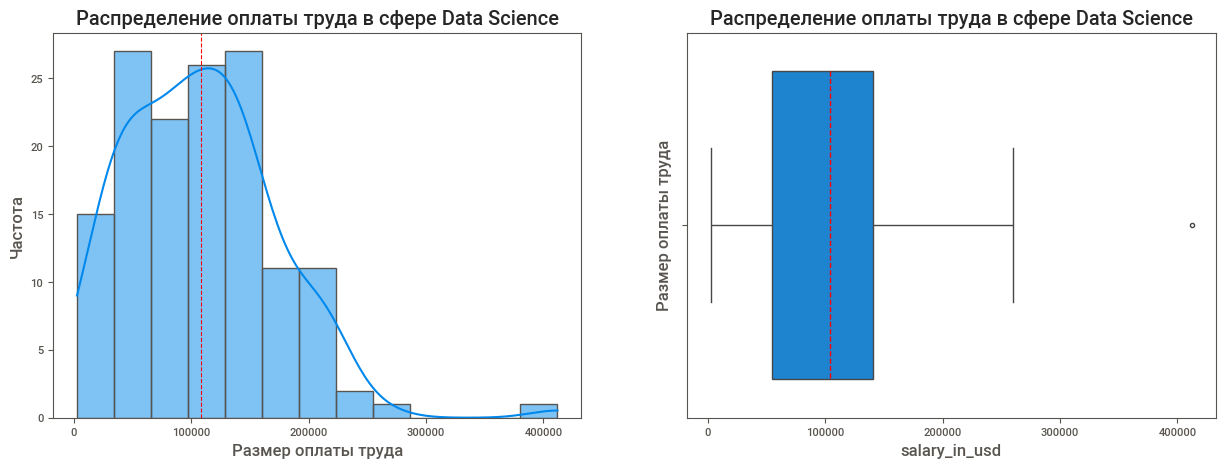

In [9]:
filtered_data = data[data['job_title'] == 'Data Scientist']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(filtered_data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер оплаты труда', ylabel='Частота')
axes[0].set_title('Распределение оплаты труда в сфере Data Science')
axes[0].axvline(filtered_data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(filtered_data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер оплаты труда')
axes[1].set_title('Распределение оплаты труда в сфере Data Science')

plt.show()

In [10]:
data_agg = filtered_data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер страховых выплат']
data_agg

,Размер страховых выплат
count,143.00
mean,108187.83
std,64112.84
min,2859.00
25%,54724.00
50%,103691.00
75%,140850.00
max,412000.00


    Вывод: Распределение оплаты труда отлично от нормального, имеются выбросы.

##### **Оплата труда в зависимости от года, в котором была выплачена зарплата:**

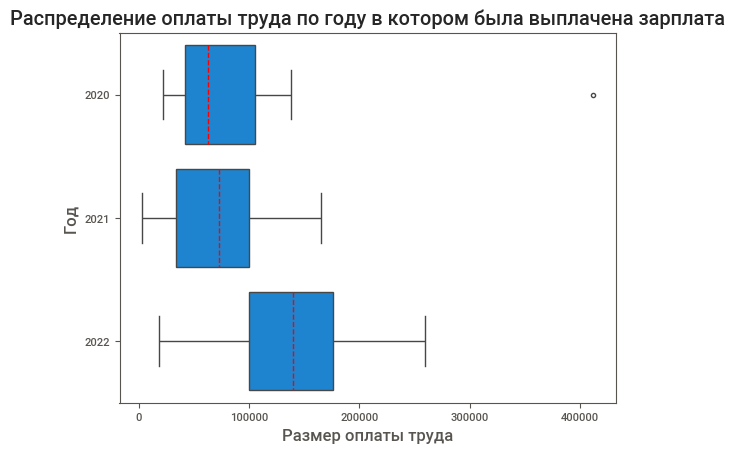

In [13]:
ax = sns.boxplot(filtered_data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер оплаты труда', ylabel='Год')
plt.title('Распределение оплаты труда по году в котором была выплачена зарплата')
plt.show()

In [14]:
data_agg = filtered_data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Распределение оплаты труда по году в котором была выплачена зарплата')
data_agg

Распределение оплаты труда по году в котором была выплачена зарплата


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.0,62726.0,105000.0,412000.0
2021,45.0,70671.73,45422.97,2859.0,33808.0,73000.0,100000.0,165000.0
2022,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


    Вывод: Распределение оплаты труда по году в котором была выплачена зарплата имеет тенденцию к уверенному увеличению средних и медианных значений за период с 2020 по 2022 гг.. В тоже время прослеживается уменьшение количества выбросов и уменьшение максимальных значений, что может свидетельствовать о росте спроса на данные виды специальностей в ИТ, так же о стадартизации квалификационных требований и компетенций самих соискателей, что выражено в уменьшении разницы между минимальными и максимальными величинами оплаты труда. Чтобы определить, являются ли эти различия статистически значимыми, проведём статистические тесты.

##### **Оплата труда в зависимости от опыта работы соискателя:**

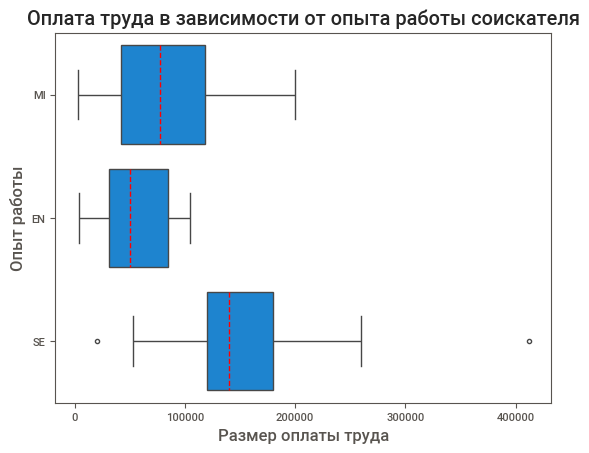

In [15]:
ax = sns.boxplot(filtered_data, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер оплаты труда', ylabel='Опыт работы')
plt.title('Оплата труда в зависимости от опыта работы соискателя')
plt.show()

In [16]:
data_agg = filtered_data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Оплата труда в зависимости от опыта работы соискателя')
data_agg

Оплата труда в зависимости от опыта работы соискателя


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,60.0,82039.13,46869.58,2859.0,41768.0,77479.0,118264.75,200000.0
SE,61.0,152971.02,58985.40,20171.0,120000.0,140400.0,180000.00,412000.0


    Вывод: Среднее значение оплаты труда увеличивается с опытом работы соискателя. Поэтому чтобы определить, являются ли эти различия статистически значимыми, проведём статистические тесты.

##### **Зависимость оплаты труда от типа трудоустройства:**

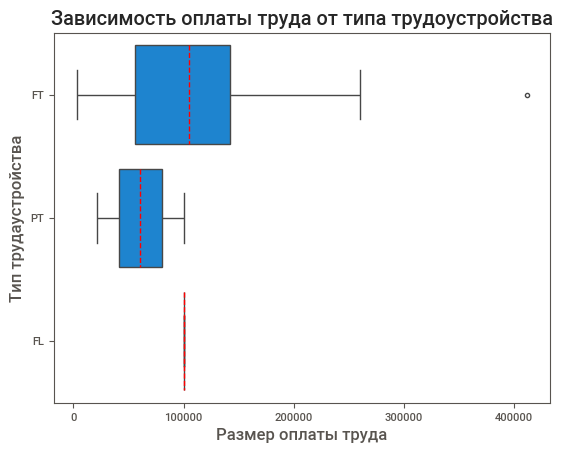

In [17]:
ax = sns.boxplot(filtered_data, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер оплаты труда', ylabel='Тип трудаустройства')
plt.title('Зависимость оплаты труда от типа трудоустройства')
plt.show()

In [18]:
data_agg = filtered_data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Зависимость оплаты труда от типа трудоустройства')
data_agg

Зависимость оплаты труда от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
FL,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
FT,140.0,108922.79,64372.43,2859.0,55490.00,104796.0,141975.00,412000.0
PT,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0


    Вывод: Распределения страховых выплат различны для разных типов трудоустройства. Чтобы определить, являются ли эти различия статистически значимыми, необходимы статистические тесты.

##### **Зависимость оплаты труда от страны проживания в течении рабочего года:**

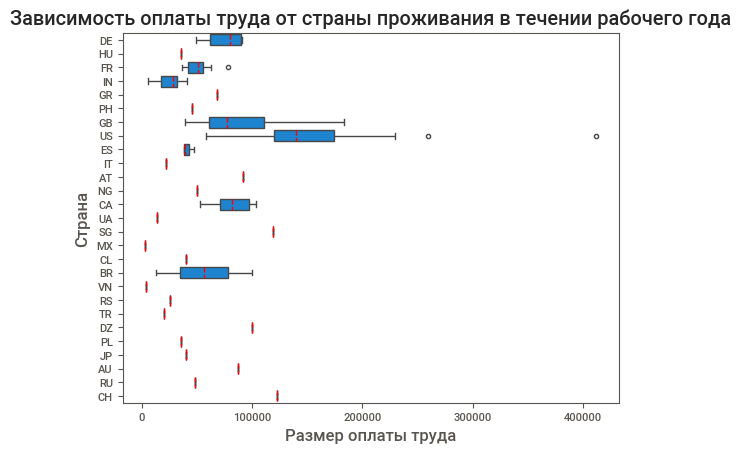

In [19]:
ax = sns.boxplot(filtered_data, x='salary_in_usd', y='employee_residence', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер оплаты труда', ylabel='Страна')
plt.title('Зависимость оплаты труда от страны проживания в течении рабочего года')
plt.show()

In [20]:
data_agg = filtered_data.groupby('employee_residence')['salary_in_usd'].describe().round(2)
print('Зависимость оплаты труда от страны проживания в течении рабочего года')
data_agg

Зависимость оплаты труда от страны проживания в течении рабочего года


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
AT,1.0,91237.00,NaN,91237.0,91237.00,91237.0,91237.00,91237.0
AU,1.0,86703.00,NaN,86703.0,86703.00,86703.0,86703.00,86703.0
BR,2.0,56450.50,61588.29,12901.0,34675.75,56450.5,78225.25,100000.0
CA,6.0,81489.17,19500.74,52396.0,70945.50,81756.0,96934.50,103691.0
CH,1.0,122346.00,NaN,122346.0,122346.00,122346.0,122346.00,122346.0
CL,1.0,40038.00,NaN,40038.0,40038.00,40038.0,40038.00,40038.0
DE,7.0,74773.71,16834.87,49268.0,62096.50,79833.0,89694.00,90734.0
DZ,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
ES,3.0,41136.67,4935.34,37825.0,38300.50,38776.0,42792.50,46809.0


    Вывод: Среднее значение оплаты труда значительно отличается по разным странам проживания соискателей. Чтобы определить, являются ли эти различия статистически значимыми, необходимы статистические тесты.

##### **Зависимость оплаты труда от доли работы, выполняемой удаленно:**

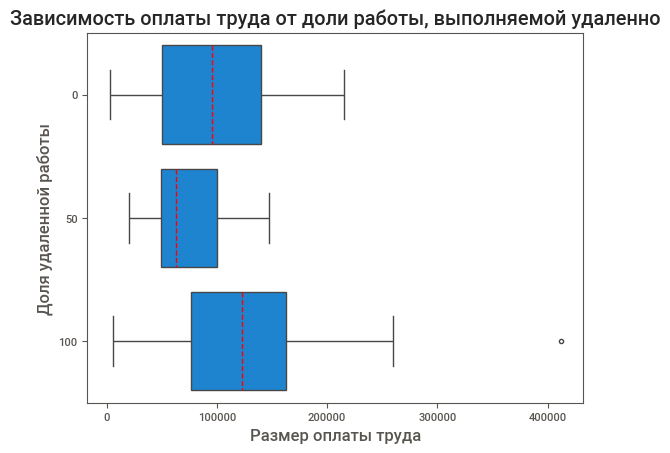

In [21]:
ax = sns.boxplot(filtered_data, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер оплаты труда', ylabel='Доля удаленной работы')
plt.title('Зависимость оплаты труда от доли работы, выполняемой удаленно')
plt.show()

In [22]:
data_agg = filtered_data.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Зависимость оплаты труда от доли работы, выполняемой удаленно')
data_agg

Зависимость оплаты труда от доли работы, выполняемой удаленно


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,39.0,99520.74,58259.42,2859.0,50294.5,95550.0,140400.0,215300.0
50,25.0,74504.08,35602.82,20171.0,49646.0,62726.0,100000.0,147000.0
100,79.0,123125.94,69370.99,5679.0,76366.0,123000.0,162500.0,412000.0


    Вывод: Среднее значение оплаты труда значительно отличается в зависимости от доли работы, выполняемой удаленно. Чтобы определить, являются ли эти различия статистически значимыми, необходимы статистические тесты.

##### **Зависимость заработной платы от страны где размещен главный офис компании:**

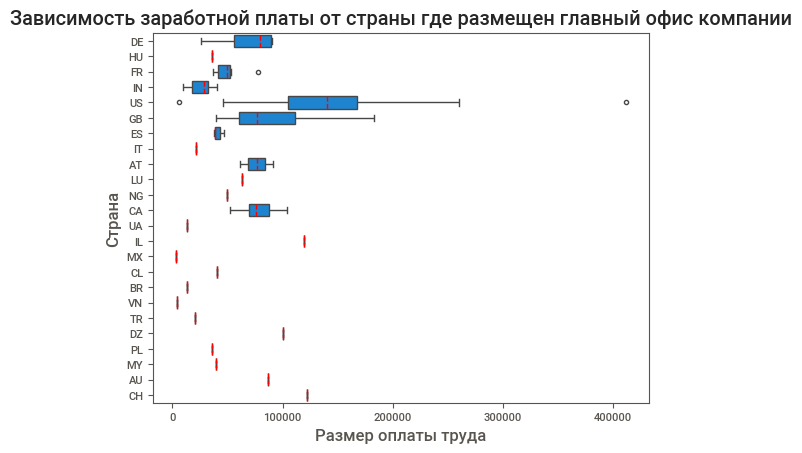

In [23]:
ax = sns.boxplot(filtered_data, x='salary_in_usd', y='company_location', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер оплаты труда', ylabel='Страна')
plt.title('Зависимость заработной платы от страны где размещен главный офис компании')
plt.show()

In [24]:
data_agg = filtered_data.groupby('company_location')['salary_in_usd'].describe().round(2)
print('Зависимость заработной платы от страны где размещен главный офис компании')
data_agg

Зависимость заработной платы от страны где размещен главный офис компании


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
AT,2.0,76352.00,21050.57,61467.0,68909.5,76352.0,83794.50,91237.0
AU,1.0,86703.00,NaN,86703.0,86703.0,86703.0,86703.00,86703.0
BR,1.0,12901.00,NaN,12901.0,12901.0,12901.0,12901.00,12901.0
CA,5.0,77787.00,19301.65,52396.0,69336.0,75774.0,87738.00,103691.0
CH,1.0,122346.00,NaN,122346.0,122346.0,122346.0,122346.00,122346.0
CL,1.0,40038.00,NaN,40038.0,40038.0,40038.0,40038.00,40038.0
DE,7.0,69640.14,25045.56,25532.0,55997.0,79833.0,89694.00,90734.0
DZ,1.0,100000.00,NaN,100000.0,100000.0,100000.0,100000.00,100000.0
ES,3.0,41136.67,4935.34,37825.0,38300.5,38776.0,42792.50,46809.0


    Вывод: Среднее значение оплаты труда значительно отличается по разным странам размещения головного офиса компании. Чтобы определить, являются ли эти различия статистически значимыми, необходимы статистические тесты.

##### **Зависимость размера заработной платы от размеров компании:**

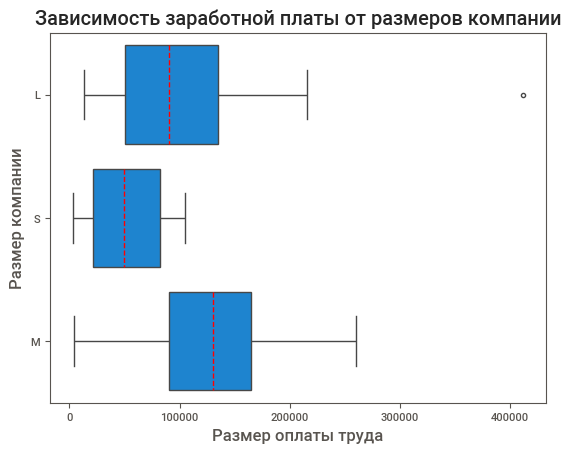

In [25]:
ax = sns.boxplot(filtered_data, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер оплаты труда', ylabel='Размер компании')
plt.title('Зависимость заработной платы от размеров компании')
plt.show()

In [26]:
data_agg = filtered_data.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Зависимость заработной платы от размера компании')
data_agg

Зависимость заработной платы от размера компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,45.0,103313.36,71815.18,13400.0,50000.0,90734.0,135000.0,412000.0
M,77.0,126380.75,56389.53,4000.0,90000.0,130000.0,165000.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


    Вывод: Среднее значение оплаты труда значительно отличается в зависимости от компании. Чтобы определить, являются ли эти различия статистически значимыми, необходимы статистические тесты.

### **Статистический анализ данных**

In [27]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))

# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

#### **Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?**

Распределение признака на протяжении 2020, 2021 и 2022 года является временным ряжом, что не попадает под категорию рассматриваемых тестов. Проведем попарные выборочные тесты.

***Проверка на нормальность***

*С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:*

*Нулевая гипотеза ($H_0$): распределение данные является нормальным.*

*Альтернативная гипотеза ($H_1$): распределение данных отлично от нормального.*

In [28]:
# задаем уровень, с которым будем сравнивать для 2021 года
data_agg = filtered_data.groupby('company_size')['salary_in_usd'].describe().round(2)
salary_2020 = data_agg['mean'].iloc[0]
salary_2021 = data_agg['mean'].iloc[1]

# проверим нормальность распеределения зарплат в 2021 году
salary__2021 = filtered_data[filtered_data['work_year'] == 2021]['salary_in_usd']
salary__2022 = filtered_data[filtered_data['work_year'] == 2022]['salary_in_usd']

# проведем тест Шапиро-Уилка
print('Для 2021:')
result = stats.shapiro(salary__2021)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(salary__2022)
decision_normality(result[1])

Для 2021:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Сформулируем нулевую и альтернативные гипотезы**

Нулевая гипотеза ($H_0$): размер зарплат у специалистов Data Scientist в 2020 г. ($μ_1$) меньше или равен размеру зарплат у специалистов Data Scientist в 2021 г. ($μ_2$) и размер зарплат у специалистов Data Scientist в 2021 г. ($μ_2$) меньше или равен размеру зарплат у специалистов Data Scientist в 2022 г. ($μ_3$), рост отсутствует.

$$ H_0 : μ_1 <= μ_2 <= μ_3$$

Альтернативная гипотеза ($H_1$): размер зарплат у специалистов Data Scientist в 2020 г. ($μ_1$) больше размера зарплат у специалистов Data Scientist в 2021 г. ($μ_2$) и размер зарплат у специалистов Data Scientist в 2021 г. ($μ_2$) больше размера зарплат у специалистов Data Scientist в 2022 г. ($μ_3$), рост отсутствует.

$$ H_1 : μ_1 > μ_2 > μ_3$$

**Выберем подходящий статистический тест**

* У признака заработная плата - количественный тип.
* 1 сравнимая группа.
* Распределение нориальное.

Для проверки нашей гипотезы можно использовать одновыборочный t-критерий.

**Проведем тест:**

In [29]:
# проводим тест
_, p = stats.ttest_1samp(salary__2021, popmean=salary_2020, alternative='greater')
print('2021:')
decision_hypothesis(p)

_, p = stats.ttest_1samp(salary__2022, popmean=salary_2021, alternative='greater')
print('2022:')
decision_hypothesis(p)

2021:
p-value = 1.000
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
2022:
p-value = 0.060
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


    Вывод: поскольку для двух последовательных периодов гипотезы получили различный результат, сделать вывод о ежегодном росте не представляется возможным. Рост средней заработной платы наблюдается только в 2022 году по отношению к 2021 году.